# Calculate metrics: accuracy, recision, recall

In [1]:
import time
import copy
import random

import torch
import torchvision
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters

In [2]:
EPOCHS = 15
BATCH_SIZE = 8
LR = 0.0001

if torch.cuda.is_available():
    TARGET = 'cuda'
else:
    TARGET = 'cpu'

# Load train and test MNIST datasets

In [3]:
train = torchvision.datasets.MNIST('', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                       ]))

test = torchvision.datasets.MNIST('', train=False, download=True,
                       transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                       ]))

train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)

# CNN (input - [batch_size, 1, 28, 28], output [batch_size, 10])

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 64, 5)
        
        self.fc1 = torch.nn.Linear(4*4*64, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, (2, 2))
        
        x = x.view(-1, 4*4*64) # flattrern
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = self.fc2(x)
        return torch.sigmoid(x)
    
print(Net())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


# CNN train

In [5]:
net = Net().to(TARGET)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
bce_loss = torch.nn.BCELoss()

best_net = Net().to(TARGET)
best_loss = torch.tensor(10e10)

for epoch in range(EPOCHS):
    time.sleep(1)
    loss = 0
    
    desc = f'Epoch: {epoch+1}/{EPOCHS}'
    
    for data in tqdm(train_dataloader, desc=desc): 
        x_train, y_train = data
        x_train /= 255.0
        
        x_train = x_train.to(TARGET)
        y_train = y_train.to(TARGET)
    
        net.zero_grad() 
        output = net(x_train)
        
        y_train_ans = torch.zeros(output.size()).float().to(TARGET)
        for i in range(y_train.size()[0]):
            y_train_ans[i, y_train[i]] = 1
        
        loss = bce_loss(output, y_train_ans)
        
        loss.backward()
        optimizer.step()
    
    print('Loss', loss.item())
    
    if loss < best_loss:
        best_net = copy.deepcopy(net)
        best_loss = loss

time.sleep(0.1)
print('Best loss', best_loss.item())

Epoch: 1/15: 100%|██████████| 7500/7500 [00:26<00:00, 285.71it/s]


Loss 0.3232976496219635


Epoch: 2/15: 100%|██████████| 7500/7500 [00:26<00:00, 283.01it/s]


Loss 0.23575036227703094


Epoch: 3/15: 100%|██████████| 7500/7500 [00:26<00:00, 284.10it/s]


Loss 0.11476599425077438


Epoch: 4/15: 100%|██████████| 7500/7500 [00:26<00:00, 284.34it/s]


Loss 0.06303590536117554


Epoch: 5/15: 100%|██████████| 7500/7500 [00:26<00:00, 285.25it/s]


Loss 0.020465288311243057


Epoch: 6/15: 100%|██████████| 7500/7500 [00:26<00:00, 283.24it/s]


Loss 0.05997247248888016


Epoch: 7/15: 100%|██████████| 7500/7500 [00:26<00:00, 281.32it/s]


Loss 0.05877641960978508


Epoch: 8/15: 100%|██████████| 7500/7500 [00:26<00:00, 280.81it/s]


Loss 0.05183357745409012


Epoch: 9/15: 100%|██████████| 7500/7500 [00:26<00:00, 282.70it/s]


Loss 0.005289566237479448


Epoch: 10/15: 100%|██████████| 7500/7500 [00:26<00:00, 282.43it/s]


Loss 0.024102825671434402


Epoch: 11/15: 100%|██████████| 7500/7500 [00:26<00:00, 279.97it/s]


Loss 0.009881634265184402


Epoch: 12/15: 100%|██████████| 7500/7500 [00:26<00:00, 283.82it/s]


Loss 0.011156990192830563


Epoch: 13/15: 100%|██████████| 7500/7500 [00:26<00:00, 284.73it/s]


Loss 0.017534267157316208


Epoch: 14/15: 100%|██████████| 7500/7500 [00:26<00:00, 278.08it/s]


Loss 0.007016581483185291


Epoch: 15/15: 100%|██████████| 7500/7500 [00:26<00:00, 284.12it/s]


Loss 0.006232151295989752
Best loss 0.005289566237479448


Item 1324
Predict 8
Real 8


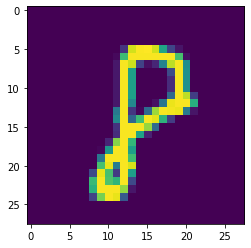

In [6]:
i = random.randint(0, len(test))
print('Item', i)

net_result = best_net(test[i][0].unsqueeze(0).to(TARGET))
real = test[i][1]

print('Predict', np.argmax(net_result.cpu().detach().numpy()))
print('Real', real)

plt.imshow(test[i][0].view(28,28))
plt.show()

# Confusion matrix

In [7]:
confusion_matrix = torch.zeros((10, 10), dtype=torch.long)

In [8]:
for i in tqdm(range(len(test))):
    img = test[i][0]
    result = best_net(img.unsqueeze(0).to(TARGET))[0]
    predict = np.argmax(result.cpu().detach().numpy())
    
    real = test[i][1]
    
    confusion_matrix[real, predict] += 1

100%|██████████| 10000/10000 [00:07<00:00, 1339.38it/s]


In [9]:
confusion_matrix

tensor([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
        [   0, 1132,    2,    0,    0,    1,    0,    0,    0,    0],
        [  16,   25,  977,    3,    1,    1,    3,    4,    2,    0],
        [  22,   60,   10,  888,    1,    9,    0,   13,    6,    1],
        [   6,   34,    5,    0,  923,    0,    5,    1,    0,    8],
        [  27,   46,    1,   15,    8,  772,   21,    1,    1,    0],
        [  30,   25,    4,    0,   17,    2,  880,    0,    0,    0],
        [   7,   44,   33,    1,    7,    3,    0,  928,    0,    5],
        [  70,   55,    8,    9,   20,    3,   21,   21,  758,    9],
        [  24,   32,    0,    7,   87,    8,    0,   48,    0,  803]])

# Accuracy

In [10]:
tp = torch.zeros((1), dtype=torch.float32)
fp = torch.zeros((1), dtype=torch.float32)

for i in range(confusion_matrix.shape[0]):  # actual 
    for j in range(confusion_matrix.shape[1]):  # predict
        if i == j:   
            tp += confusion_matrix[i, j]
        else:
            fp += confusion_matrix[i, j]
            
accuracy = (tp / (tp + fp))
print(f'Accuracy: {accuracy.item()}')

Accuracy: 0.9039000272750854


# Precision

In [19]:
precision = torch.zeros(confusion_matrix.shape[0], dtype=torch.float32)

for cls in range(confusion_matrix.shape[0]):
    c = confusion_matrix[cls, cls].float()
    s = confusion_matrix[:, cls].sum().float()
    
    precision[cls] = c / s

for cls in range(precision.shape[0]):
    print(f'Precision. Class {cls}: {precision[cls]}')

Precision. Class 0: 0.8288135528564453
Precision. Class 1: 0.7790777683258057
Precision. Class 2: 0.9394230842590332
Precision. Class 3: 0.962080180644989
Precision. Class 4: 0.8674812316894531
Precision. Class 5: 0.96620774269104
Precision. Class 6: 0.9452201724052429
Precision. Class 7: 0.9124876856803894
Precision. Class 8: 0.9882659912109375
Precision. Class 9: 0.972154974937439


# Macro precision

In [12]:
macro_precision = precision.sum() / precision.shape[0]
print(f'Macro precision: {macro_precision.item()}')

Macro precision: 0.9161211252212524


# Recall

In [13]:
recall = torch.zeros(confusion_matrix.shape[0], dtype=torch.float32)

for cls in range(confusion_matrix.shape[1]):
    c = confusion_matrix[cls, cls].float()
    s = confusion_matrix[cls, :].sum().float()
    
    recall[cls] = c / s

for cls in range(recall.shape[0]):
    print(f'Recall. Class {cls}: {recall[cls]}')

Recall. Class 0: 0.9979591965675354
Recall. Class 1: 0.9973568320274353
Recall. Class 2: 0.9467054009437561
Recall. Class 3: 0.8792079091072083
Recall. Class 4: 0.9399185180664062
Recall. Class 5: 0.865470826625824
Recall. Class 6: 0.9185803532600403
Recall. Class 7: 0.9027237296104431
Recall. Class 8: 0.77823406457901
Recall. Class 9: 0.7958374619483948


# Macro recall

In [14]:
macro_recall = recall.sum() / recall.shape[0]
print(f'Macro recall: {macro_recall.item()}')

Macro recall: 0.9021994471549988


# F1 score

In [15]:
f1_score = 2 * ((precision * recall) / (precision + recall))

for cls in range(f1_score.shape[0]):
    print(f'F1 score. Class {cls}: {f1_score[cls]}')

F1 score. Class 0: 0.9055555462837219
F1 score. Class 1: 0.8748067617416382
F1 score. Class 2: 0.94305020570755
F1 score. Class 3: 0.9187791347503662
F1 score. Class 4: 0.9022483229637146
F1 score. Class 5: 0.9130691289901733
F1 score. Class 6: 0.931709885597229
F1 score. Class 7: 0.9075794219970703
F1 score. Class 8: 0.8707639575004578
F1 score. Class 9: 0.87520432472229


# Macro F1 score

In [16]:
macro_f1_score = f1_score.sum() / f1_score.shape[0]
print(f'Macro F1 score: {macro_f1_score.item()}')

Macro F1 score: 0.9042766690254211


# Weighted precision

In [23]:
weighted_precision = torch.zeros((1), dtype=torch.float32)

for cls in range(precision.shape[0]):
    weighted_precision += precision[cls] * confusion_matrix[cls, cls].float()
    
weighted_precision /= confusion_matrix.sum()
print(f'Weighted precision: {weighted_precision.item()}')

Weighted precision: 0.82195645570755


# Weighted recall

In [24]:
weighted_recall = torch.zeros((1), dtype=torch.float32)

for cls in range(recall.shape[0]):
    weighted_recall += recall[cls] * confusion_matrix[cls, cls].float()
    
weighted_recall /= confusion_matrix.sum()
print(f'Weighted recall: {weighted_recall.item()}')

Weighted recall: 0.8221405148506165


# Weighted F1 score

In [21]:
weighted_f1_score = torch.zeros((1), dtype=torch.float32)

for cls in range(f1_score.shape[0]):
    weighted_f1_score += f1_score[cls] * confusion_matrix[cls, cls].float()

weighted_f1_score /= confusion_matrix.sum()
print(f'Weighted F1 score: {weighted_f1_score.item()}')

Weighted F1 score: 0.8175781965255737
